<a href="https://colab.research.google.com/github/sonsalmon/TransAnomaly/blob/main/%08TransAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 코드로 형식 지정됨

```
# 코드로 형식 지정됨
```


```

# TransAnomaly 
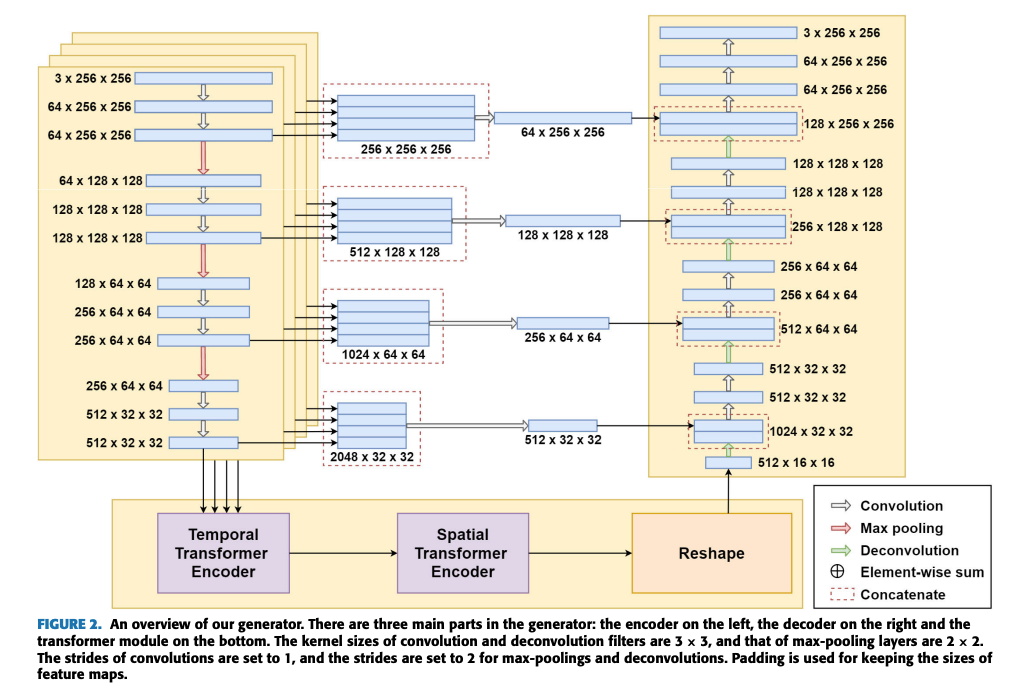


# Dataset
주행차

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Deep-Learning'



Mounted at /content/drive


In [ ]:

import sys
sys.path = sys.path[:10]
sys.path.append(base_path + '/ViViT') # sys.path : 모듈 경로

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## setup libraries & device

In [ ]:
import os, sys
import natsort # 숫자 정렬용
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import einsum

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from module import Attention, PreNorm, FeedForward
import cv2
from google.colab.patches import cv2_imshow # colab에서 cv2.imshow 사용 불가
sys.path

ModuleNotFoundError: ignored

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)


cpu


## data sample

600
['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg', '00077.

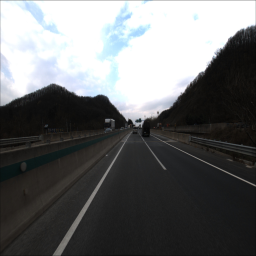

(3, 256, 256)
<class 'numpy.ndarray'>


In [ ]:
train_dir = os.path.join(base_path, "dashcam_data")

train_fns = os.listdir(train_dir) #file 목록 리스트로 저장
train_fns = natsort.natsorted(train_fns)

print(len(train_fns))
print(train_fns)

sample_image_fp = os.path.join(train_dir, train_fns[0])
# sample_image = Image.open(sample_image_fp)#.convert("RGB")
sample_image = cv2.imread(sample_image_fp)
sample_image = cv2.resize(sample_image,dsize=(256,256), interpolation=cv2.INTER_AREA) # 256 X 256 사이즈로 변환
cv2_imshow(sample_image)# (1200,1920,3)
sample_image = sample_image.transpose(2, 0, 1) #(c, h, w)으로 축 변환
print(sample_image.shape)
print(type(sample_image))


## Define Dataset
커스텀 데이터 셋 : https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html  
https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html  
dataloader : https://hayunjong83.tistory.com/47
#### To Do
- 해상도 (3,1200,1920) -> (3,256,256)으로 변환
- Dataset class 정의
- 각 데이터는 (t, c, h, w) = (시퀀스 길이, 채널, 높이, 너비)
- Dataloader 정의


In [ ]:
class DashcamDataset(Dataset):
    def __init__(self, self, annotations_file, img_dir, transform=None, target_transform=None):
    
    def __len__:

        return len(self.img_labels)
    
    def __getitem__:

        return image, label

## Define Model

vit code 리뷰 : https://yhkim4504.tistory.com/5

code reference
- U-Net : https://jovian.ai/chakravarthy-sudharshan/semantic-segmentation-cityscapes/v/1?utm_source=embed
- ViViT : https://github.com/rishikksh20/ViViT-pytorch

1. unet encoder가 t개의 frame 동시에 각각 처리후 transformer로 넘겨줘야함.   
이 때 t개의 encoder는 같은 parameter를 공유함.

2. 

- input frame의 해상도 : (3,256,256)기준으로 함. 이때 featuremap 해상도 = (-1, 32,32)

In [ ]:

class TransAnomaly(nn.Module):
    def __init__(self, batch_size, num_frames):
        super(UNet, self).__init__()
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.channels_1 = 64 #endcoder 기준 1번째 layer의 채널
        self.channels_2 = 128
        self.channels_3 = 256
        self.channels_4 = 512

        self.contracting_11 = self.conv_block(in_channels=3, out_channels=self.channels_1) #3 * 256 * 256 -> 64*256*256
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2) # (64,128,128)
        self.contracting_21 = self.conv_block(in_channels=self.channels_1, out_channels=self.channels_2)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2) #(128,64,64)
        self.contracting_31 = self.conv_block(in_channels=self.channels_2, out_channels=self.channels_3) #(256,64,64)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2) #(256,32,32)
        self.contracting_41 = self.conv_block(in_channels=self.channels_3, out_channels=self.channels_4) #(512,32,32)

        self.residual_14 = nn.Conv2d(in_channels=self.channels_1*self.num_frames, out_channels=self.channels_1, kernel_size=3, stride=1, padding=1)
        self.residual_23 = nn.Conv2d(in_channels=self.channels_2*self.num_frames, out_channels=self.channels_2, kernel_size=3, stride=1, padding=1)
        self.residual_32 = nn.Conv2d(in_channels=self.channels_3*self.num_frames, out_channels=self.channels_3, kernel_size=3, stride=1, padding=1)
        self.residual_41 = nn.Conv2d(in_channels=self.channels_4*self.num_frames, out_channels=self.channels_4, kernel_size=3, stride=1, padding=1)

        self.middle = ViViT(image_size=32, patch_size=4, num_classes, num_frame) #(b,t,c,h,w) = (b, 4, 512,32,32) -> (b,c,h,w) = (b,512,16,16)
        # input : (512,16,16)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=self.channels_4, out_channels=self.channels_4, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.expansive_12 = self.conv_block(in_channels=self.channels_4*2, out_channels=self.channels_4) #(512,32,32)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=self.channels_4, out_channels=self.channels_3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=self.channels_3*2, out_channels=self.channels_3)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=self.channels_3, out_channels=self.channels_2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=self.channels_2*2, out_channels=self.channels_2)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=self.channels_2, out_channels=self.channels_1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=self.channels_1*2, out_channels=self.channels_1)
        self.output = nn.Conv2d(in_channels=self.channels_1, out_channels=3, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    

    def forward(self, frames):
        #frames.shape = (batch, num_frames, c, h ,w) --reshape--> (batch * num_frames, c, h, w) 
        #batch * num_frames을 batch size로 가지도록 conv2d 수행 후 다시 batch, num_frames,로 reshape하자.
        ########## encoding #######
        tmp_frames = rearrange(frames, 'b t c h w -> (b t) c h w') 
        contracting_11_out = self.contracting_11(frames) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        ############

        ####### vivit layer ########
        vivit_input = rearrange(contracting_41_out, '(b t) c h w -> b t c h w', b=self.batch_size)
        middle_out = self.middle(vivit_input) # [batch_size, num_frames , 512, 32, 32]
        #middle_out.shape should be (b, c, h, w) = (-1, 512, 16,16) (논문에 제시된 형태에 따르면)
        ############
        
        ######### residual connect #####
        #contracting_xx_out.shape = ((b*t), c, h ,w) 
        #이걸 (b, t*c, h w)로 만든 다음 convolution 해야함. 
        #convolution 후 shape => (b, c, h ,w) 되도록 (즉, t차원 사라지게 됨.)
        #이걸 디코딩할 때 concate함. 
        #residual_XY -> X : endcoding layer 번호, Y : decoding layer 번호 (u자 형태이기 떄문에 1번 레이어와 4번 레이어가 연결됨.)
        residual_14_out = rearrange(contracting_11_out, '(b t) c h w -> b (t c) h w', b=self.batch_size)
        residual_14_out = residual_14(residual_14_out) #shape = (b,c,h,w) : (64,256,256)
        residual_23_out = rearrange(contracting_21_out, '(b t) c h w -> b (t c) h w', b=self.batch_size)
        residual_23_out = residual_23(residual_23_out)#shape = (b,c,h,w) : (128,128,128)
        residual_32_out = rearrange(contracting_31_out, '(b t) c h w -> b (t c) h w', b=self.batch_size)
        residual_32_out = residual_14(residual_32_out)#shape = (b,c,h,w) : (256,64,64)
        residual_41_out = rearrange(contracting_41_out, '(b t) c h w -> b (t c) h w', b=self.batch_size)
        residual_41_out = residual_41(residual_41_out)#shape = (b,c,h,w) : (512,32,32)


        ####### decoding ##########
        #vivit의 output 받아옴.
        expansive_11_out = self.expansive_11(middle_out) # output의 shape = [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, residual_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, residual_32_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, residual_23_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, residual_14_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        ############
        return output_out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


#수정필요
#transformer에 pretrained vit 적용해야함.
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2 #patch의 차원 = c * p^2
        self.to_patch_embedding = nn.Sequential(
            #Batch X Time X Channel X H X W 형태 이미지 -> Batch X Time X N X (patch_size*patch_size*Channel) (이때 N = H*W / P*P) 형태 벡터로 임베딩
            #1X16X3X(14*16)X(14*16) -> 1X16X(14*14)X(16*16*3)
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim), #input 차원 = patch_dim, output 차원 = dim인 MLP 
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim)) #space_token 붙으니까 num_patches + 1
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        print(x.shape)
        x = self.to_patch_embedding(x)
        print(x.shape)
        b, t, n, _ = x.shape
        #space_token을 반복해서 배치와 시간의 크기와 맞춰준다.
        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t) # (1,1,192) -> (1,16,1,192)
        #cls_space_token과  projected x 를 이어붙임(concatenate)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)] # 아마 space_token 때문에 +1
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        print('space befoer shaep: ', x.shape)
        x = self.space_transformer(x) # ???
        print('space after shaep: ', x.shape)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)
        print('before x shape : ', x.shape)
        x = self.temporal_transformer(x) #transformer 지나도 shape 안 바뀜
        # x = rearrange(x, 'b n d -> ') reshape 과정 필요 -> (512,16,16)
        print('after x shape : ', x.shape)



        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)

In [ ]:
# optimizer, objective function 설정
model = TransAnomaly().to(DEVICE)
#
# optimizer, criterion 선정 필요
#
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) 
criterion = nn.CrossEntropyLoss()

print(model)

# 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (frames, label) in enumerate(train_loader):  #frames.shape = (t,c,h,w), labels.shape = (t,y)
        frames = frames.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        ouput = model(frames)
        loss = criterion(ouput, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

# 학습 과정에서 검증데이터에 ㄷ한 모델 성능 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

#10 MLP학습 진행
for Epoch in range(1, EPOCHS +1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy)